# Mosquito Larvae Classification - Aedes aegypti vs Culex quinquefasciatus
This notebook trains a CNN model from scratch to classify mosquito larvae species.

In [1]:
CONFIG = {
    # Data
    "data_path": "MLMI-2024-organized",
    "img_size": 224,
    "batch_size": 32,
    "augment": True,

    # Training
    "epochs": 10,
    "lr": 1e-3,
    "optimizer": "adam",  # adam | sgd
    "weight_decay": 1e-4,
    "label_smoothing": 0.0,

    # Architecture
    "use_batchnorm": True,
    "dropout": 0.3,

    # Evaluation
    "use_gradcam": True,
    "output_dir": "experiments/run_1",
}

In [2]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import os

def get_transforms(cfg, train=True):
    t = [transforms.Resize((cfg["img_size"], cfg["img_size"]))]

    if train and cfg["augment"]:
        t += [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(0.2, 0.2, 0.2),
        ]

    t += [transforms.ToTensor()]
    return transforms.Compose(t)

def get_dataloaders(cfg):
    """
    Creates DataLoaders for train and test sets using the structure:
    dataset/
      train/
      test/
    """
    train_transform = get_transforms(cfg, train=True)
    test_transform = get_transforms(cfg, train=False)

    # Use data path from config
    base_path = cfg.get("data_path", "dataset")
    train_dir = os.path.join(base_path, "train")
    test_dir = os.path.join(base_path, "test")

    # Check if directories exist
    if not os.path.exists(train_dir):
        print(f"WARNING: Train directory not found at {train_dir}")
        print("Please ensure 'dataset/train' and 'dataset/test' exist.")
    
    try:
        train_ds = datasets.ImageFolder(train_dir, train_transform)
        test_ds = datasets.ImageFolder(test_dir, test_transform)

        print(f"Train dataset: {len(train_ds)} images")
        print(f"Test dataset: {len(test_ds)} images")
        print(f"Classes: {train_ds.classes}")

        train_dl = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True, num_workers=0)
        test_dl = DataLoader(test_ds, batch_size=cfg["batch_size"], shuffle=False, num_workers=0)
        
        return train_dl, test_dl
    except Exception as e:
        print(f"Error loading datasets: {e}")
        return None, None

## Data Leakage Check
Before training, we verify that there are no duplicate or near-duplicate images between train and test sets. This checks for:
1. **Exact duplicates** - using MD5 hash
2. **Near duplicates** - using perceptual hashing
3. **Filename overlaps** - suspicious naming patterns

⚠️ **Note**: You'll need to install `imagehash` if not already installed: `pip install imagehash`

In [3]:
import hashlib
from pathlib import Path
from collections import defaultdict
import imagehash
from PIL import Image

def check_data_leakage(data_path, hash_size=8):
    """
    Check for data leakage between train and test sets.
    
    Args:
        data_path: Path to dataset root (containing train/ and test/)
        hash_size: Size for perceptual hash (default 8)
    
    Returns:
        dict with leakage statistics
    """
    print("="*70)
    print("DATA LEAKAGE CHECK")
    print("="*70)
    
    base_path = Path(data_path)
    train_dir = base_path / "train"
    test_dir = base_path / "test"
    
    if not train_dir.exists() or not test_dir.exists():
        print("ERROR: Train or test directory not found!")
        return None
    
    # 1. Check for exact duplicates using MD5 hash
    print("\n1. Checking for EXACT duplicates (MD5 hash)...")
    
    def compute_md5(file_path):
        """Compute MD5 hash of file"""
        hash_md5 = hashlib.md5()
        with open(file_path, "rb") as f:
            for chunk in iter(lambda: f.read(4096), b""):
                hash_md5.update(chunk)
        return hash_md5.hexdigest()
    
    # Get all image files
    train_files = list(train_dir.rglob("*.jpg")) + list(train_dir.rglob("*.png"))
    test_files = list(test_dir.rglob("*.jpg")) + list(test_dir.rglob("*.png"))
    
    print(f"   Train images: {len(train_files)}")
    print(f"   Test images: {len(test_files)}")
    
    # Compute hashes
    print("   Computing MD5 hashes for train set...")
    train_hashes = {compute_md5(f): f for f in train_files}
    
    print("   Computing MD5 hashes for test set...")
    test_hashes = {compute_md5(f): f for f in test_files}
    
    # Find exact matches
    exact_duplicates = set(train_hashes.keys()) & set(test_hashes.keys())
    
    if exact_duplicates:
        print(f"\n   ⚠️  WARNING: Found {len(exact_duplicates)} EXACT duplicate(s)!")
        for i, hash_val in enumerate(list(exact_duplicates)[:5], 1):
            print(f"      {i}. Train: {train_hashes[hash_val].name}")
            print(f"         Test:  {test_hashes[hash_val].name}")
        if len(exact_duplicates) > 5:
            print(f"      ... and {len(exact_duplicates) - 5} more")
    else:
        print("   ✓ No exact duplicates found!")
    
    # 2. Check for near-duplicates using perceptual hash
    print(f"\n2. Checking for NEAR duplicates (perceptual hash, size={hash_size})...")
    print("   This may take a moment...")
    
    def compute_perceptual_hash(file_path, hash_size=8):
        """Compute perceptual hash using average hash"""
        try:
            img = Image.open(file_path)
            return imagehash.average_hash(img, hash_size=hash_size)
        except Exception as e:
            print(f"   Error processing {file_path}: {e}")
            return None
    
    # Compute perceptual hashes
    train_phashes = {}
    for f in train_files:
        h = compute_perceptual_hash(f, hash_size)
        if h is not None:
            train_phashes[f] = h
    
    test_phashes = {}
    for f in test_files:
        h = compute_perceptual_hash(f, hash_size)
        if h is not None:
            test_phashes[f] = h
    
    # Find similar images (hamming distance <= 5)
    similar_pairs = []
    threshold = 5  # Hamming distance threshold
    
    for test_file, test_hash in test_phashes.items():
        for train_file, train_hash in train_phashes.items():
            distance = test_hash - train_hash
            if distance <= threshold:
                similar_pairs.append((train_file, test_file, distance))
    
    if similar_pairs:
        print(f"\n   ⚠️  WARNING: Found {len(similar_pairs)} near-duplicate pair(s)!")
        print(f"   (Hamming distance <= {threshold})")
        for i, (train_f, test_f, dist) in enumerate(similar_pairs[:5], 1):
            print(f"      {i}. Distance={dist}")
            print(f"         Train: {train_f.name}")
            print(f"         Test:  {test_f.name}")
        if len(similar_pairs) > 5:
            print(f"      ... and {len(similar_pairs) - 5} more")
    else:
        print(f"   ✓ No near duplicates found (threshold={threshold})!")
    
    # 3. Check filename patterns
    print("\n3. Checking for suspicious filename overlaps...")
    train_names = set(f.name for f in train_files)
    test_names = set(f.name for f in test_files)
    
    name_overlaps = train_names & test_names
    if name_overlaps:
        print(f"   ⚠️  WARNING: {len(name_overlaps)} files with same name in train and test!")
        for i, name in enumerate(list(name_overlaps)[:5], 1):
            print(f"      {i}. {name}")
        if len(name_overlaps) > 5:
            print(f"      ... and {len(name_overlaps) - 5} more")
    else:
        print("   ✓ No filename overlaps found!")
    
    # Summary
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    leakage_found = exact_duplicates or similar_pairs or name_overlaps
    
    if leakage_found:
        print("❌ POTENTIAL DATA LEAKAGE DETECTED!")
        print(f"   - Exact duplicates: {len(exact_duplicates)}")
        print(f"   - Near duplicates: {len(similar_pairs)}")
        print(f"   - Filename overlaps: {len(name_overlaps)}")
        print("\n⚠️  Please review and fix the data split before training!")
    else:
        print("✓ NO DATA LEAKAGE DETECTED")
        print("  Train and test sets are properly separated.")
    
    print("="*70)
    
    return {
        "exact_duplicates": len(exact_duplicates),
        "near_duplicates": len(similar_pairs),
        "filename_overlaps": len(name_overlaps),
        "leakage_detected": leakage_found
    }

# Run the data leakage check
leakage_results = check_data_leakage(CONFIG["data_path"])

DATA LEAKAGE CHECK

1. Checking for EXACT duplicates (MD5 hash)...
   Train images: 560
   Test images: 240
   Computing MD5 hashes for train set...
   Computing MD5 hashes for test set...
   ✓ No exact duplicates found!

2. Checking for NEAR duplicates (perceptual hash, size=8)...
   This may take a moment...

   ⚠️  WARNING: Found 19482 near-duplicate pair(s)!
   (Hamming distance <= 5)
      1. Distance=4
         Train: 20231107_113540.jpg
         Test:  20231107_113902.jpg
      2. Distance=2
         Train: 20231107_114014.jpg
         Test:  20231107_113902.jpg
      3. Distance=4
         Train: 20231107_122207.jpg
         Test:  20231107_113902.jpg
      4. Distance=5
         Train: 20231107_131504.jpg
         Test:  20231107_113902.jpg
      5. Distance=1
         Train: 20231107_135023.jpg
         Test:  20231107_113902.jpg
      ... and 19477 more

3. Checking for suspicious filename overlaps...
   ✓ No filename overlaps found!

SUMMARY
❌ POTENTIAL DATA LEAKAGE DETECTE

## Investigate Near-Duplicates
If near-duplicates were detected, use the cells below to investigate them further.

Finding near-duplicate pairs (distance <= 5)...


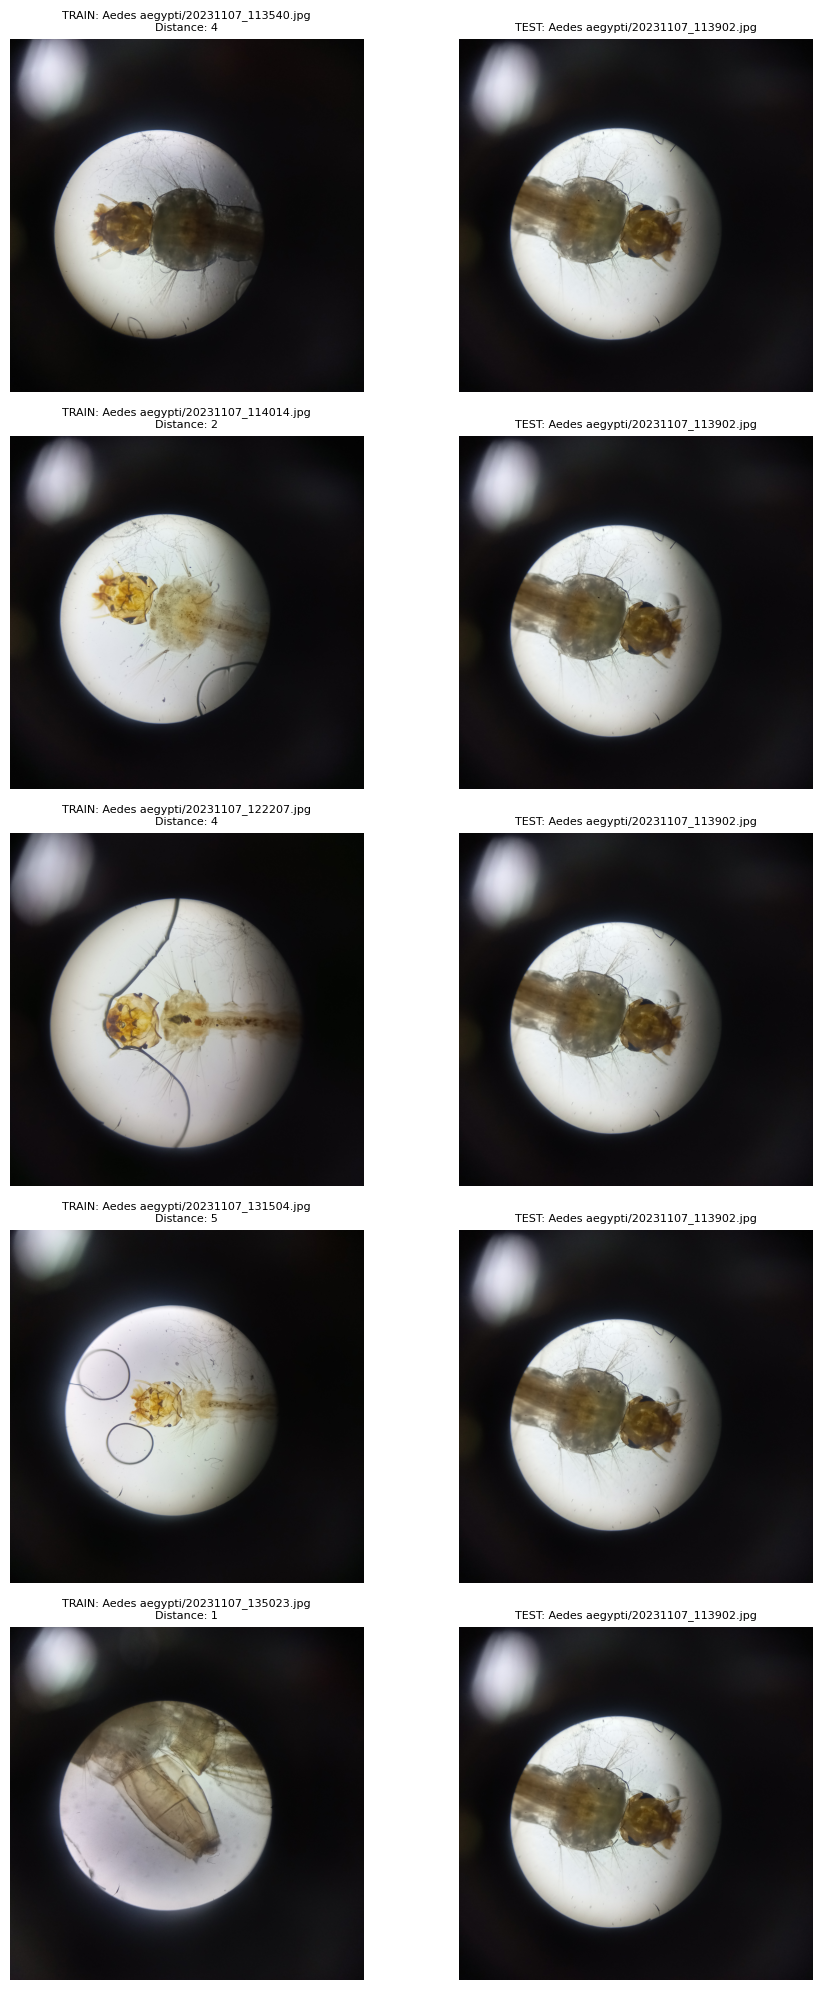


Inspect the pairs above:
- If they look like the SAME mosquito specimen → TRUE LEAKAGE
- If they're DIFFERENT mosquitoes but similar → FALSE POSITIVE (OK)


In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import imagehash

def visualize_duplicate_pairs(data_path, num_pairs=5, max_distance=5):
    """
    Visualize near-duplicate pairs to manually inspect them.
    
    Args:
        data_path: Path to dataset root
        num_pairs: Number of pairs to visualize
        max_distance: Maximum hamming distance to consider
    """
    base_path = Path(data_path)
    train_dir = base_path / "train"
    test_dir = base_path / "test"
    
    # Get image files
    train_files = list(train_dir.rglob("*.jpg")) + list(train_dir.rglob("*.png"))
    test_files = list(test_dir.rglob("*.jpg")) + list(test_dir.rglob("*.png"))
    
    print(f"Finding near-duplicate pairs (distance <= {max_distance})...")
    
    # Compute hashes
    train_hashes = {}
    for f in train_files[:100]:  # Limit to first 100 for quick check
        try:
            img = Image.open(f)
            train_hashes[f] = imagehash.average_hash(img, hash_size=8)
        except:
            pass
    
    test_hashes = {}
    for f in test_files[:50]:  # Limit to first 50 for quick check
        try:
            img = Image.open(f)
            test_hashes[f] = imagehash.average_hash(img, hash_size=8)
        except:
            pass
    
    # Find pairs
    pairs = []
    for test_file, test_hash in test_hashes.items():
        for train_file, train_hash in train_hashes.items():
            distance = test_hash - train_hash
            if distance <= max_distance:
                pairs.append((train_file, test_file, distance))
                if len(pairs) >= num_pairs:
                    break
        if len(pairs) >= num_pairs:
            break
    
    # Visualize
    if not pairs:
        print("No pairs found in sample!")
        return
    
    fig, axes = plt.subplots(len(pairs), 2, figsize=(10, 4*len(pairs)))
    if len(pairs) == 1:
        axes = [axes]
    
    for idx, (train_f, test_f, dist) in enumerate(pairs):
        # Load images
        train_img = Image.open(train_f)
        test_img = Image.open(test_f)
        
        # Plot train
        axes[idx][0].imshow(train_img)
        axes[idx][0].set_title(f"TRAIN: {train_f.parent.name}/{train_f.name}\nDistance: {dist}", fontsize=8)
        axes[idx][0].axis('off')
        
        # Plot test
        axes[idx][1].imshow(test_img)
        axes[idx][1].set_title(f"TEST: {test_f.parent.name}/{test_f.name}", fontsize=8)
        axes[idx][1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nInspect the pairs above:")
    print("- If they look like the SAME mosquito specimen → TRUE LEAKAGE")
    print("- If they're DIFFERENT mosquitoes but similar → FALSE POSITIVE (OK)")

# Visualize some duplicate pairs
visualize_duplicate_pairs(CONFIG["data_path"], num_pairs=5, max_distance=5)

In [5]:
def analyze_leakage_statistics(data_path, distance_threshold=5):
    """
    Provide detailed statistics about potential duplicates.
    """
    from pathlib import Path
    import imagehash
    from PIL import Image
    from collections import defaultdict
    
    base_path = Path(data_path)
    train_dir = base_path / "train"
    test_dir = base_path / "test"
    
    print("="*70)
    print("DETAILED LEAKAGE ANALYSIS")
    print("="*70)
    
    # Get files
    train_files = list(train_dir.rglob("*.jpg")) + list(train_dir.rglob("*.png"))
    test_files = list(test_dir.rglob("*.jpg")) + list(test_dir.rglob("*.png"))
    
    print(f"\n📊 Dataset Statistics:")
    print(f"   Train images: {len(train_files)}")
    print(f"   Test images: {len(test_files)}")
    print(f"   Max possible pairs: {len(train_files) * len(test_files):,}")
    
    # Compute hashes (sample for speed)
    print("\n🔍 Computing perceptual hashes (sampling)...")
    sample_size = min(200, len(train_files))
    train_sample = train_files[:sample_size]
    test_sample = test_files[:min(100, len(test_files))]
    
    train_hashes = {}
    for f in train_sample:
        try:
            img = Image.open(f)
            train_hashes[f] = imagehash.average_hash(img, hash_size=8)
        except:
            pass
    
    test_hashes = {}
    for f in test_sample:
        try:
            img = Image.open(f)
            test_hashes[f] = imagehash.average_hash(img, hash_size=8)
        except:
            pass
    
    # Analyze distances
    distances = []
    for test_hash in list(test_hashes.values())[:20]:
        for train_hash in list(train_hashes.values())[:20]:
            distances.append(test_hash - train_hash)
    
    if distances:
        print(f"\n📈 Distance Distribution (sample of {len(distances)} pairs):")
        print(f"   Min distance: {min(distances)}")
        print(f"   Max distance: {max(distances)}")
        print(f"   Mean distance: {sum(distances)/len(distances):.2f}")
        print(f"   Median distance: {sorted(distances)[len(distances)//2]}")
        
        # Count by threshold
        for thresh in [3, 5, 8, 10]:
            count = sum(1 for d in distances if d <= thresh)
            pct = (count / len(distances)) * 100
            print(f"   Pairs with distance ≤ {thresh:2d}: {count:4d} ({pct:5.1f}%)")
    
    print("\n💡 RECOMMENDATIONS:")
    
    if len(distances) > 0:
        similar_pct = (sum(1 for d in distances if d <= 5) / len(distances)) * 100
        
        if similar_pct > 50:
            print("   ⚠️  HIGH similarity detected (>50% of pairs have distance ≤ 5)")
            print("   This is COMMON for biological images of the same species!")
            print("\n   Options:")
            print("   1. INCREASE threshold to 3 or less for stricter checking")
            print("   2. Manually inspect pairs using visualization above")
            print("   3. If images are different individuals → PROCEED with training")
            print("   4. Check if same specimen appears in both sets → FIX split")
        elif similar_pct > 20:
            print("   ⚠️  MODERATE similarity (20-50% of pairs)")
            print("   Recommend manual inspection of flagged pairs")
        else:
            print("   ✓ LOW similarity detected (<20% of pairs)")
            print("   Most flagged pairs are likely different specimens")
    
    print("\n" + "="*70)

# Run detailed analysis
analyze_leakage_statistics(CONFIG["data_path"], distance_threshold=5)

DETAILED LEAKAGE ANALYSIS

📊 Dataset Statistics:
   Train images: 560
   Test images: 240
   Max possible pairs: 134,400

🔍 Computing perceptual hashes (sampling)...

📈 Distance Distribution (sample of 400 pairs):
   Min distance: 0
   Max distance: 25
   Mean distance: 11.58
   Median distance: 12
   Pairs with distance ≤  3:   14 (  3.5%)
   Pairs with distance ≤  5:   37 (  9.2%)
   Pairs with distance ≤  8:  114 ( 28.5%)
   Pairs with distance ≤ 10:  167 ( 41.8%)

💡 RECOMMENDATIONS:
   ✓ LOW similarity detected (<20% of pairs)
   Most flagged pairs are likely different specimens



In [7]:
import torch.nn as nn
import torch.nn.functional as F

class ScratchCNN(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        def block(in_c, out_c):
            layers = [nn.Conv2d(in_c, out_c, 3, padding=1)]
            if cfg["use_batchnorm"]:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            block(3, 32),
            block(32, 64),
            block(64, 128),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(cfg["dropout"])
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).flatten(1)
        x = self.dropout(x)
        return self.fc(x)

In [8]:
from sklearn.metrics import roc_auc_score, classification_report
import torch
import numpy as np

def evaluate(model, loader, device):
    model.eval()
    y_true, y_score = [], []
    y_pred = []

    print("\nRunning Evaluation...")
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            # Forward pass
            logits = model(x)
            # Get probabilities
            probs = logits.softmax(1)[:, 1].cpu()
            # Get hard predictions
            preds = logits.argmax(1).cpu()

            y_true.extend(y.numpy())
            y_score.extend(probs.numpy())
            y_pred.extend(preds.numpy())

    # Check if we have gathered any data
    if not y_true:
        print("No evaluation data found.")
        return

    try:
        auc = roc_auc_score(y_true, y_score)
        print(f"ROC-AUC: {auc:.4f}")
    except ValueError:
        print("ROC-AUC: N/A (Only one class present in targets)")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import os
import torch
import cv2

def plot_training_curves(train_losses, train_accs, output_dir):
    plt.figure(figsize=(10, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy', color='orange')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'))
    plt.close()

def plot_confusion_matrix(y_true, y_pred, classes, output_dir):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.close()

def plot_roc_curve(y_true, y_scores, output_dir):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(output_dir, 'roc_curve.png'))
    plt.close()

def apply_gradcam(model, image_tensor, target_class=None):
    """
    Generates GradCAM heatmap for a specific image tensor.
    image_tensor: (1, C, H, W)
    """
    model.eval()
    
    # Hook to capture gradients and activations
    gradients = []
    activations = []
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
        
    def forward_hook(module, input, output):
        activations.append(output)
        
    # Hook the last convolutional layer
    handle_f = model.features.register_forward_hook(forward_hook)
    handle_b = model.features.register_full_backward_hook(backward_hook)
    
    # Forward
    output = model(image_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()
        
    # Backward
    model.zero_grad()
    score = output[0, target_class]
    score.backward()
    
    # Get captures
    grads = gradients[0].cpu().data.numpy()[0] # (C, H, W)
    fmaps = activations[0].cpu().data.numpy()[0] # (C, H, W)
    
    handle_f.remove()
    handle_b.remove()
    
    # Weights = Global Average Pooling of Gradients
    weights = np.mean(grads, axis=(1, 2)) # (C,)
    
    # Weighted combination of feature maps
    cam = np.zeros(fmaps.shape[1:], dtype=np.float32) # (H, W)
    for i, w in enumerate(weights):
        cam += w * fmaps[i]
        
    # ReLU
    cam = np.maximum(cam, 0)
    
    # Normalize
    if np.max(cam) > 0:
        cam = cam / np.max(cam)
    else:
        cam = cam # avoid div by zero
        
    return cam

def save_gradcam_image(image_tensor, cam, output_path, label_text):
    # Denormalize image for visualization
    img = image_tensor.cpu().numpy().transpose(1, 2, 0) # (H, W, C)
    img = (img - img.min()) / (img.max() - img.min()) # Scale to 0-1
    img = np.uint8(255 * img)
    
    # Resize cam to image size
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose
    superimposed_img = heatmap * 0.4 + img * 0.6
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    # Add label
    cv2.putText(superimposed_img, label_text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    cv2.imwrite(output_path, superimposed_img)

In [10]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import time
import os
import random

def get_optimizer(cfg, model):
    if cfg["optimizer"] == "adam":
        print(f"Using Adam optimizer with lr={cfg['lr']}, weight_decay={cfg['weight_decay']}")
        return Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    print(f"Using SGD optimizer with lr={cfg['lr']}, momentum=0.9, weight_decay={cfg['weight_decay']}")
    return SGD(model.parameters(), lr=cfg["lr"], momentum=0.9, weight_decay=cfg["weight_decay"])

def train_model():
    # 0. Setup Output Dir
    os.makedirs(CONFIG["output_dir"], exist_ok=True)
    print(f"Outputs will be saved in: {CONFIG['output_dir']}")

    # 1. Setup
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on: {DEVICE}")
    
    # 2. Data
    print("Loading data...")
    train_dl, test_dl = get_dataloaders(CONFIG)
    
    if train_dl is None or test_dl is None:
        print("Data loading failed.")
        return

    # 3. Model
    print("Initializing from-scratch model...")
    model = ScratchCNN(CONFIG).to(DEVICE)
    
    # 4. Optimization
    optimizer = get_optimizer(CONFIG, model)
    criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG["label_smoothing"])
    
    # Trackers
    train_losses = []
    train_accs = []
    
    # 5. Training Loop
    print(f"Starting training for {CONFIG['epochs']} epochs...")
    start_time = time.time()
    
    for epoch in range(CONFIG["epochs"]):
        model.train()
        correct, total, loss_sum = 0, 0, 0
        
        for i, (x, y) in enumerate(train_dl):
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
            
        # Stats
        epoch_acc = correct / total if total > 0 else 0
        avg_loss = loss_sum / len(train_dl) if len(train_dl) > 0 else 0
        
        train_losses.append(avg_loss)
        train_accs.append(epoch_acc)
        
        print(f"[Epoch {epoch+1:02d}/{CONFIG['epochs']}] Loss={avg_loss:.4f} Acc={epoch_acc:.4f}")
        
    total_time = time.time() - start_time
    print(f"Training finished in {total_time:.2f}s")
    
    # Save training curves
    print("Generating training curves...")
    plot_training_curves(train_losses, train_accs, CONFIG["output_dir"])
    
    # 6. Evaluation
    print("\nEvaluating on Test Set...")
    model.eval()
    y_true, y_score, y_pred = [], [], []
    
    with torch.no_grad():
        for x, y in test_dl:
            x = x.to(DEVICE)
            logits = model(x)
            probs = logits.softmax(1)[:, 1].cpu()
            preds = logits.argmax(1).cpu()

            y_true.extend(y.numpy())
            y_score.extend(probs.numpy())
            y_pred.extend(preds.numpy())
            
    # Save Model
    save_path = os.path.join(CONFIG["output_dir"], "scratch_cnn_mosq.pth")
    torch.save(model.state_dict(), save_path)
    print(f"\nModel saved to {save_path}")
    
    # Generate Plots
    print("Generating ROC Curve...")
    plot_roc_curve(y_true, y_score, CONFIG["output_dir"])
    
    print("Generating Confusion Matrix...")
    classes = ["Aedes aegypti", "Culex quinquefasciatus"]
    plot_confusion_matrix(y_true, y_pred, classes, CONFIG["output_dir"])
    
    # 7. GradCAM Generation
    if CONFIG["use_gradcam"]:
        print("Generating GradCAM samples...")
        model.eval()
        gradcam_dir = os.path.join(CONFIG["output_dir"], "gradcam")
        os.makedirs(gradcam_dir, exist_ok=True)
        
        # Pick 5 random images from test set
        inputs, labels = next(iter(test_dl))
        indices = random.sample(range(len(inputs)), min(5, len(inputs)))
        
        for idx in indices:
            img_tensor = inputs[idx].unsqueeze(0).to(DEVICE) # (1, 3, H, W)
            label = labels[idx].item()
            class_name = classes[label]
            
            # Predict
            out = model(img_tensor)
            pred = out.argmax(1).item()
            pred_name = classes[pred]
            
            # Generate CAM
            cam = apply_gradcam(model, img_tensor, target_class=pred)
            
            # Save
            fname = f"cam_{idx}_true_{class_name}_pred_{pred_name}.jpg"
            save_path = os.path.join(gradcam_dir, fname)
            label_text = f"True: {class_name}, Pred: {pred_name}"
            save_gradcam_image(img_tensor[0], cam, save_path, label_text)
            print(f"Saved {save_path}")

    # Text Evaluation
    evaluate(model, test_dl, DEVICE)
    
    print("\n" + "="*50)
    print("Training and Evaluation Complete!")
    print("="*50)

## Run Training
Execute the cell below to start the training process.

In [11]:
# Run the training
train_model()

Outputs will be saved in: experiments/run_1
Running on: cuda
Loading data...
Train dataset: 560 images
Test dataset: 240 images
Classes: ['Aedes aegypti', 'Culex quinquefasciatus']
Initializing from-scratch model...
Using Adam optimizer with lr=0.001, weight_decay=0.0001
Starting training for 10 epochs...
[Epoch 01/10] Loss=0.6658 Acc=0.6071
[Epoch 02/10] Loss=0.5996 Acc=0.6786
[Epoch 03/10] Loss=0.5888 Acc=0.7125
[Epoch 04/10] Loss=0.5729 Acc=0.7196
[Epoch 05/10] Loss=0.5872 Acc=0.7143
[Epoch 06/10] Loss=0.5813 Acc=0.6786
[Epoch 07/10] Loss=0.5580 Acc=0.6964
[Epoch 08/10] Loss=0.5778 Acc=0.7125
[Epoch 09/10] Loss=0.5531 Acc=0.7429
[Epoch 10/10] Loss=0.5506 Acc=0.7304
Training finished in 730.52s
Generating training curves...

Evaluating on Test Set...

Model saved to experiments/run_1\scratch_cnn_mosq.pth
Generating ROC Curve...
Generating Confusion Matrix...
Generating GradCAM samples...


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Saved experiments/run_1\gradcam\cam_24_true_Aedes aegypti_pred_Aedes aegypti.jpg
Saved experiments/run_1\gradcam\cam_9_true_Aedes aegypti_pred_Aedes aegypti.jpg
Saved experiments/run_1\gradcam\cam_4_true_Aedes aegypti_pred_Aedes aegypti.jpg
Saved experiments/run_1\gradcam\cam_23_true_Aedes aegypti_pred_Culex quinquefasciatus.jpg
Saved experiments/run_1\gradcam\cam_13_true_Aedes aegypti_pred_Culex quinquefasciatus.jpg

Running Evaluation...
ROC-AUC: 0.7810

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.4167    0.5882       120
           1     0.6316    1.0000    0.7742       120

    accuracy                         0.7083       240
   macro avg     0.8158    0.7083    0.6812       240
weighted avg     0.8158    0.7083    0.6812       240


Training and Evaluation Complete!
